In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.7.0


## data loading

In [3]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

FileNotFoundError: File TCIR-ALL_2017.h5 does not exist

In [3]:
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0


In [4]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4580 entries, 0 to 4579
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_set   4580 non-null   object 
 1   ID         4580 non-null   object 
 2   lon        4580 non-null   float64
 3   lat        4580 non-null   float64
 4   time       4580 non-null   object 
 5   Vmax       4580 non-null   float64
 6   R35_4qAVG  4580 non-null   float64
 7   MSLP       4580 non-null   float64
dtypes: float64(5), object(3)
memory usage: 322.0+ KB


In [5]:
np.shape(data_matrix)

(4580, 201, 201, 4)

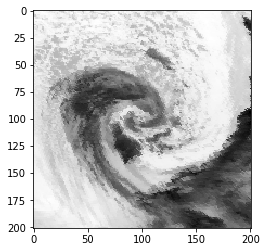

In [6]:
img = data_matrix[4,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

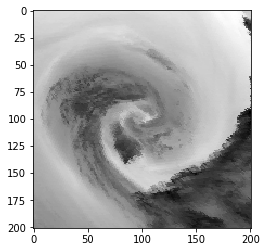

In [7]:
img = data_matrix[4,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [ ]:
data_path_1 = "/home/ec2-user/SageMaker/DeHurricane/data_downloaded/TCIR-ATLN_EPAC_WPAC.h5"
data_info_1 = pd.read_hdf(data_path_1, key="info", mode='r')
data_info_1.head()

In [ ]:
data_path_2 = "/home/ec2-user/SageMaker/DeHurricane/data_downloaded/TCIR-CPAC_IO_SH.h5"
data_info_2 = pd.read_hdf(data_path_2, key="info", mode='r')
data_info_2.head()
print(len(data_info), len(data_info_1), len(data_info_2))

Is there missing value?

In [ ]:
data_info.isna().sum(axis=0)
data_info_1.isna().sum(axis=0)
data_info_2.isna().sum(axis=0)

In [ ]:
data_info.data_set.unique()
data_info_1.data_set.unique()
data_info_2.data_set.unique()

In [ ]:
data_info.groupby('ID').count()
data_info_1.groupby('ID').count().head()
data_info_2.groupby('ID').count().head()

In [ ]:
data_info_1.iloc[-1]
data_info_2.iloc[-1]

In [ ]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

Is it true that for every ID the increase in time is 3 hours?

In [ ]:
data_info[['ID', 'time']].groupby('ID').diff().nunique()

In [ ]:
data_info_1 = data_info.assign(time=pd.to_datetime(data_info_1.time, format=r'%Y%m%d%H'))
data_info_2 = data_info.assign(time=pd.to_datetime(data_info_2.time, format=r'%Y%m%d%H'))

In [ ]:
data_info_1[['ID', 'time']].groupby('ID').diff().nunique()
data_info_2[['ID', 'time']].groupby('ID').diff().nunique()

## Data preprocessing

In [103]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [104]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [106]:
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.2)

In [107]:
# kf = KFold(n_splits=2)
# for train_index, test_index in kf.split(X_irpmw):
#     print("TEST:", len(list(train_index)), type(list(test_index)))
#     X_train, X_test = X_irpmw[train_index], X_irpmw[test_index]
#     y_train, y_test = y[train_index], y[test_index]

X_tensor = tf.convert_to_tensor(X_irpmw)
y = tf.convert_to_tensor(y)

### Standardization

In [11]:
X_std = tf.image.per_image_standardization(X_tensor)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [12]:
img = X_std[0,:,:,:]
print(np.mean(img), np.std(img))

1.3218921e-07 0.9999998


## Preprocessing layers

In [13]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [14]:
pp = Preprocessing()

In [15]:
rotated = pp(X_std[:5,:,:,:], training=True)

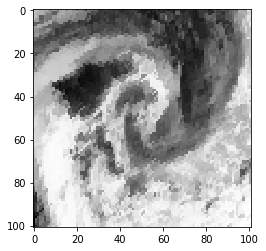

In [16]:
fig, ax = plt.subplots()
pos = ax.imshow(rotated[4,:,:,0], plt.cm.gray)

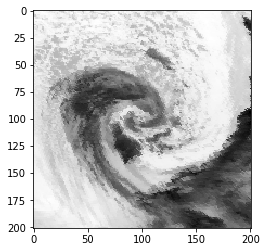

In [17]:
fig, ax = plt.subplots()
pos = ax.imshow(X_std[4,:,:,0], plt.cm.gray)

## Building a model

In [90]:
X_std[list(np.array([0,1,2]))]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.1870102, -1.0012516], dtype=float32)>

In [126]:
# input_size = len(X_std)
# output_size = 10

"""
references: 
layers API: https://keras.io/api/layers/ 

1. some parameter tuning: 
    batch size: BATCH_SIZE = 128 #@param ["64", "128", "256", "512"]
    regularizer: l1,l2 
    how to set the initial weight: weights_initializer = keras.initializers.GlorotUniform()  
    batch size: 32 
    how to choose metric?  https://www.tensorflow.org/guide/keras/train_and_evaluate  
        right now, I am using mse. 
    what is callback?  https://keras.io/api/callbacks/  
3. 3 fold cross-validation 
4. hold out data for testing 
5. all years data 
"""



#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error'], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
#     time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score

In [147]:
n_epochs=200
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=5)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 3297 samples, validate on 367 samples
Epoch 1/200
3297/3297 [==============================] - 2s 595us/sample - loss: 2165.8650 - mean_squared_error: 2165.8577 - val_loss: 412.4097 - val_mean_squared_error: 412.4028
Epoch 2/200
3297/3297 [==============================] - 1s 277us/sample - loss: 824.1450 - mean_squared_error: 824.1384 - val_loss: 276.6170 - val_mean_squared_error: 276.6106
Epoch 3/200
3297/3297 [==============================] - 1s 270us/sample - loss: 642.9134 - mean_squared_error: 642.9073 - val_loss: 251.1790 - val_mean_squared_error: 251.1729
Epoch 4/200
3297/3297 [==============================] - 1s 283us/sample - loss: 572.8717 - mean_squared_error: 572.8657 - val_loss: 233.0813 - val_mean_squared_error: 233.0753
Epoch 5/200
3297/3297 [==============================] - 1s 279us/sample - loss: 484.2605 - mean_squared_error: 484.2545 - val_loss: 349.3089 - val_mean_squared_error: 349.3028
Epoch 6/200
3297/3297 [======================

In [48]:
def plot_xy(history,title):
    fig = plt.figure()
    x=range(n_epochs)
    train_mse=history.history['loss']
    val_mse=history.history['val_loss']
    plt.plot(x,train_mse,label="train_mse")
    plt.plot(x,val_mse,label="val_mse")
    plt.xlabel('epochs')
    plt.ylabel('mse (kt^2)')
    plt.title(title)
    plt.legend()

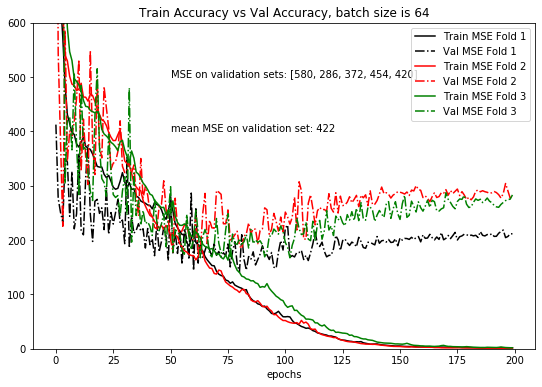

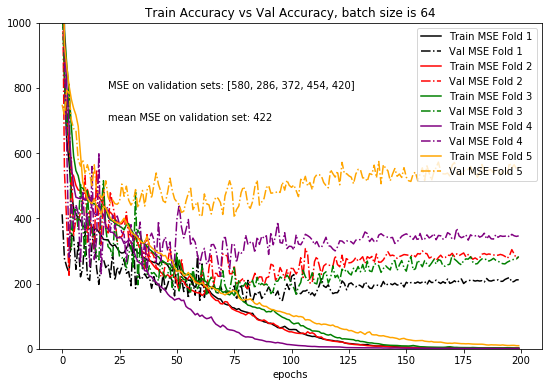

In [151]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(5):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

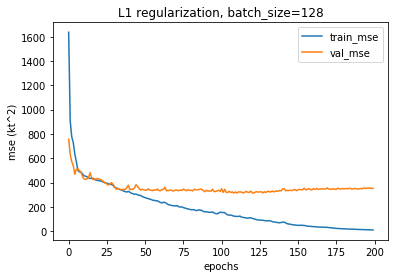

In [55]:
plot_xy(history,"L1 regularization, batch_size=128")

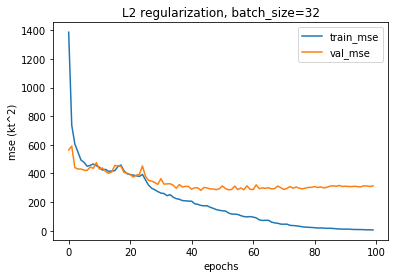

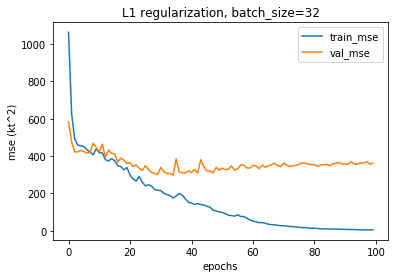

In [49]:
plot_xy(history,"L1 regularization, batch_size=32")

In [ ]:

print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)



In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_1 (Preprocessi multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  528       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  73856     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8

In [43]:
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
